# 06. Nonlinear classifiers

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=ConvergenceWarning) 


In [2]:
with np.load("train_data.npz",allow_pickle=False) as npztrain:
    train_data = dict(npztrain.items())

with np.load("valid_data.npz",allow_pickle=False) as npzvalid:
    valid_data = dict(npzvalid.items())
    
with np.load("test_data.npz",allow_pickle=False) as npztest:
    test_data = dict(npztest.items())

In [3]:
X_train,y_train = train_data.values()
X_valid,y_valid = valid_data.values()
X_test,y_test = test_data.values()

Let's start by making a random forest with 10 trees with maximum depth of 5

In [4]:
dt = Pipeline([
    ("forest",RandomForestClassifier(n_estimators=10, max_depth=5, random_state=0))
])

In [5]:
dt.fit(X_train,y_train)
print("Accuracy of Random Forest with 10 trees : {:.1f}%".format(100*dt.score(X_valid,y_valid)))

Accuracy of Random Forest with 10 trees : 90.6%


We can tune the parameters to get better result. Lets vary the number of estimators along with the depth of the trees.

In [6]:
grid = {
    "forest__n_estimators": [1,5,10,20,50,100,200],
    "forest__max_depth": [1,3,5,10,50,None]
}

In [7]:
dtcv = GridSearchCV(dt,grid,cv=5,return_train_score=True)

In [8]:
dtcv.fit(X_train,y_train);

In [9]:
print("The best parameters are \n")
for i,j in dtcv.best_params_.items():
    print("- {} : {}".format(i,j))
print("\nWith a test accuracy of {:.2f}%".format(100*dtcv.best_score_))

The best parameters are 

- forest__max_depth : 10
- forest__n_estimators : 100

With a test accuracy of 93.24%


Let's try and fine tune it 

In [10]:
fine_grid = {
    "forest__n_estimators": [30,40,50,60,80,100,150,300],
    "forest__max_depth": [5,6,7,8,9,10,10,11,12]
}

In [11]:
dtcv_fine = GridSearchCV(dt,fine_grid,cv=5,return_train_score=True)

In [12]:
dtcv_fine.fit(X_train,y_train);

In [13]:
print("The best parameters are \n")
for i,j in dtcv_fine.best_params_.items():
    print("- {} : {}".format(i,j))
print("\nWith a test accuracy of {:.2f}%".format(100*dtcv_fine.best_score_))

The best parameters are 

- forest__max_depth : 8
- forest__n_estimators : 80

With a test accuracy of 93.59%


We managed to improve the accuracy ! now let's fix the depth to see how the accuracy changes when we increase the number of trees

In [14]:
n_estimators_grid = {
    "forest__n_estimators": [50,60,80,100,150,300,500,1000],
    "forest__max_depth": [dtcv_fine.best_params_["forest__n_estimators"]]
}

In [15]:
dtcv_locked_max_depth = GridSearchCV(dt,n_estimators_grid,cv=5,return_train_score=True)

In [16]:
dtcv_locked_max_depth.fit(X_train,y_train);

In [17]:
cols = ['mean_test_score',"param_forest__n_estimators"]
cv_results = pd.DataFrame(dtcv_locked_max_depth.cv_results_,columns=cols)

In [18]:
cv_results

,mean_test_score,param_forest__n_estimators
0,0.914591,50
1,0.921708,60
2,0.921708,80
3,0.932384,100
4,0.932384,150
5,0.932384,300
6,0.925267,500
7,0.925267,1000


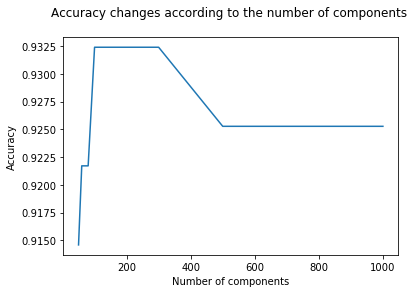

In [19]:
plt.plot(cv_results.param_forest__n_estimators,cv_results.mean_test_score)
plt.title("Accuracy changes according to the number of components \n")
plt.xlabel("Number of components")
plt.ylabel("Accuracy");

We see that the accuracy spikes at around 100 components

Let's now try with SVMs, we will start with the linear one.

In [20]:
linear_svm = Pipeline([
    ("linear_svm",LinearSVC())
])

In [21]:
grid_lin_svm = {
    "linear_svm__C":np.logspace(-4,4,num=9)
}

In [22]:
gs_lin_svm = GridSearchCV(linear_svm,grid_lin_svm,cv=5,return_train_score=True)
gs_lin_svm.fit(X_train,y_train);

In [23]:
cv_results2 = pd.DataFrame(gs_lin_svm.cv_results_)[["mean_test_score","param_linear_svm__C"]]
cv_results2.sort_values(by="mean_test_score",ascending=False).head(3)

,mean_test_score,param_linear_svm__C
3,0.94306,0.1
4,0.94306,1
5,0.94306,10


In [24]:
print("Best parameter for C :",gs_lin_svm.best_params_["linear_svm__C"])
print("Best accuracy : {:.2f}%".format(gs_lin_svm.best_score_*100))

Best parameter for C : 0.1
Best accuracy : 94.31%


Let's now use the rbf kernel one.

In [25]:
rbf_svm = Pipeline([
    ("rbf_svm",SVC())
])

In [26]:
grid_rbf = {
    "rbf_svm__C":np.logspace(-4,4,num=9),
    "rbf_svm__gamma":np.logspace(-4,4,num=9)
}

In [27]:
gs_rbf_svm = GridSearchCV(rbf_svm,grid_rbf,cv=5,return_train_score=True)

In [28]:
gs_rbf_svm.fit(X_train,y_train);

In [29]:
cv_results3 = pd.DataFrame(gs_rbf_svm.cv_results_)[["mean_test_score","param_rbf_svm__C","param_rbf_svm__gamma"]]
cv_results3.sort_values(by="mean_test_score",ascending=False).head(3)

,mean_test_score,param_rbf_svm__C,param_rbf_svm__gamma
54,0.950178,100,0.0001
46,0.946619,10,0.001
55,0.943060,100,0.001


We see that we get very similar results, let's now compute and collect our test accuracies

In [30]:
rf_test_acc = 100*dtcv_fine.score(X_test,y_test)
linsvm_test_acc = 100*gs_lin_svm.score(X_test,y_test)
rbfsvm_test_acc = 100*gs_rbf_svm.score(X_test,y_test)
print("Test accuracy random forest : {:.1f}%".format(rf_test_acc))
print("Test accuracy linear : {:.1f}%".format(linsvm_test_acc))
print("Test accuracy rbf : {:.1f}%".format(rbfsvm_test_acc))

Test accuracy random forest : 94.0%
Test accuracy linear : 92.0%
Test accuracy rbf : 92.0%


In [31]:
%store rf_test_acc
%store linsvm_test_acc
%store rbfsvm_test_acc

Stored 'rf_test_acc' (float64)
Stored 'linsvm_test_acc' (float64)
Stored 'rbfsvm_test_acc' (float64)
